### IBM Telecommunications Customer Churn Data: Exploratory Data Analysis

Ayman Siddiki

#### 1. Importing Libraries & Loading Dataset

In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

%matplotlib inline

In [9]:
# load data
df = pd.read_excel('../data/raw/Telco_customer_churn.xlsx', sheet_name='Telco_Churn')

print(f"Dataset dimensions: {df.shape}")
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")

Dataset dimensions: (7043, 33)
Rows: 7043
Columns: 33


In [12]:
#data head
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


#### 2. Initial Data Assessment

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [15]:
# check for duplicates
n_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {n_duplicates}")

# check for missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing[missing > 0],
    'Percentage': missing_pct[missing > 0]
}).sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print(missing_df)
else:
    print("No missing values.")

Number of duplicate rows: 0
              Missing Count  Percentage
Churn Reason           5174   73.463013


##### **Note:** Churn Reason has ~73% missing values, which makes sense since it's only populated for customers who actually churned.

#### 3. Target Variable Analysis

In [14]:
# churn distribution
churn_counts = df['Churn Value'].value_counts()
churn_pct = df['Churn Value'].value_counts(normalize=True) * 100

print("Churn Distribution:")
print(f"Not Churned: {churn_counts[0]:,} ({churn_pct[0]:.2f}%)")
print(f"Churned:     {churn_counts[1]:,} ({churn_pct[1]:.2f}%)")
print(f"\nChurn Rate: {churn_pct[1]:.2f}%")

Churn Distribution:
Not Churned: 5,174 (73.46%)
Churned:     1,869 (26.54%)

Churn Rate: 26.54%


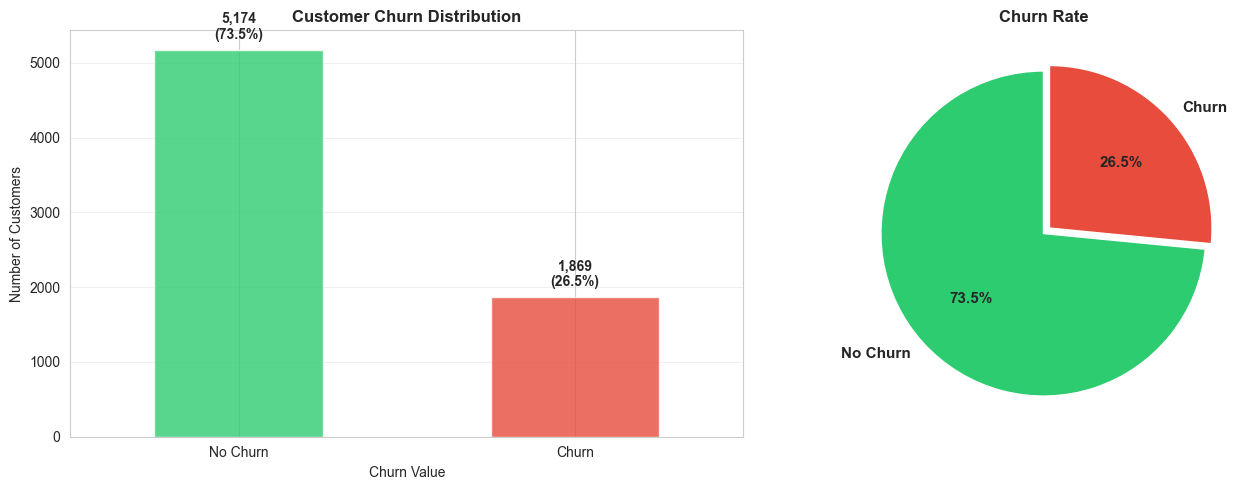

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# bar chart
ax1 = axes[0]
churn_counts.plot(kind='bar', ax=ax1, color=['#2ecc71', '#e74c3c'], alpha=0.8)
ax1.set_xticklabels(['No Churn', 'Churn'], rotation=0)
ax1.set_ylabel('Number of Customers')
ax1.set_title('Customer Churn Distribution', fontweight='bold', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

for i, v in enumerate(churn_counts):
    ax1.text(i, v + 100, f'{v:,}\n({churn_pct[i]:.1f}%)', 
             ha='center', va='bottom', fontweight='bold')

# pie chart
ax2 = axes[1]
colors = ['#2ecc71', '#e74c3c']
explode = (0, 0.05)
ax2.pie(churn_counts, labels=['No Churn', 'Churn'], autopct='%1.1f%%',
        colors=colors, explode=explode, startangle=90, textprops={'fontsize': 11, 'weight': 'bold'})
ax2.set_title('Churn Rate', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

##### **Key Finding:** About 26.5% of customers have churned. This is a significant churn rate that warrants investigation into the underlying causes.

#### 4. Numeric Features Analysis

In [17]:
# summary stats for numeric columns
numeric_cols = ['Tenure Months', 'Monthly Charges', 'Total Charges']

# need to clean Total Charges first (it's stored as object)
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

df[numeric_cols].describe().round(2)

,Tenure Months,Monthly Charges,Total Charges
count,7043.00,7043.00,7032.00
mean,32.37,64.76,2283.30
std,24.56,30.09,2266.77
min,0.00,18.25,18.80
25%,9.00,35.50,401.45
50%,29.00,70.35,1397.48
75%,55.00,89.85,3794.74
max,72.00,118.75,8684.80


#### 4.1 Tenure Analysis

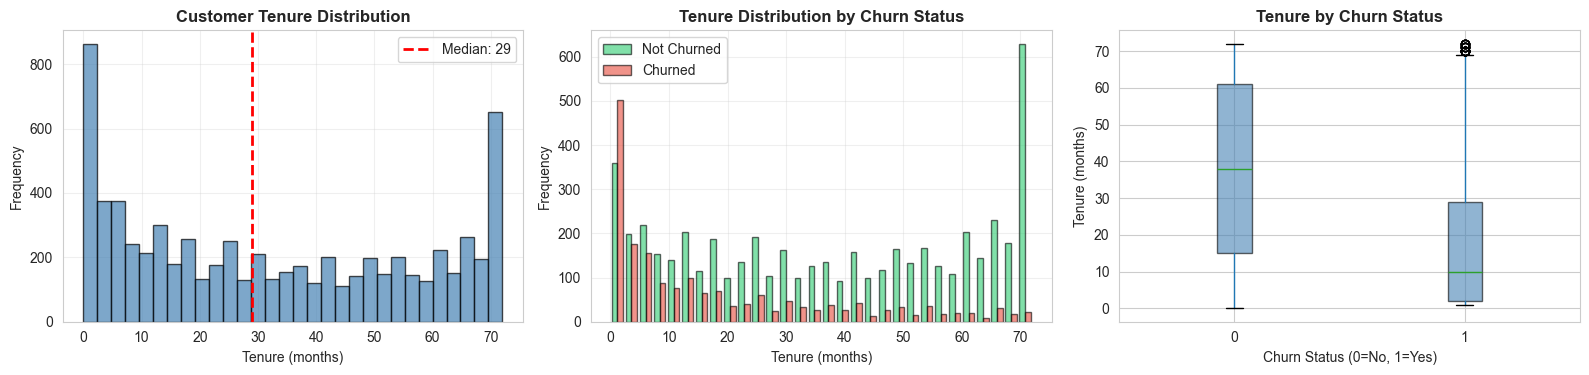


Tenure Statistics by Churn:
              count   mean    std  min   25%   50%   75%   max
Churn Value                                                   
0            5174.0  37.57  24.11  0.0  15.0  38.0  61.0  72.0
1            1869.0  17.98  19.53  1.0   2.0  10.0  29.0  72.0


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# distribution
ax1 = axes[0]
ax1.hist(df['Tenure Months'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(df['Tenure Months'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {df["Tenure Months"].median():.0f}')
ax1.set_xlabel('Tenure (months)')
ax1.set_ylabel('Frequency')
ax1.set_title('Customer Tenure Distribution', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# by churn status
ax2 = axes[1]
churned = df[df['Churn Value'] == 1]['Tenure Months']
not_churned = df[df['Churn Value'] == 0]['Tenure Months']
ax2.hist([not_churned, churned], bins=30, label=['Not Churned', 'Churned'], 
         color=['#2ecc71', '#e74c3c'], alpha=0.6, edgecolor='black')
ax2.set_xlabel('Tenure (months)')
ax2.set_ylabel('Frequency')
ax2.set_title('Tenure Distribution by Churn Status', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# box plot comparison
ax3 = axes[2]
df.boxplot(column='Tenure Months', by='Churn Value', ax=ax3, patch_artist=True,
           boxprops=dict(facecolor='steelblue', alpha=0.6))
ax3.set_xlabel('Churn Status (0=No, 1=Yes)')
ax3.set_ylabel('Tenure (months)')
ax3.set_title('Tenure by Churn Status', fontweight='bold')
plt.suptitle('')  # remove default title for better presentation.

plt.tight_layout()
plt.show()

print("\nTenure Statistics by Churn:")
print(df.groupby('Churn Value')['Tenure Months'].describe().round(2))

##### **Observation:** Customers who churned have significantly lower average tenure (~18 months) compared to those who stayed (~38 months). This suggests newer customers are at higher risk.

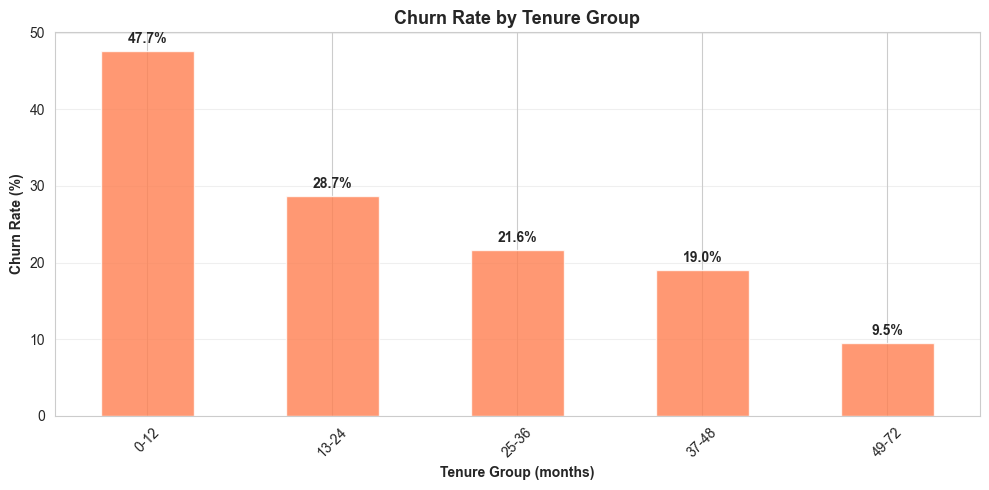

              Churned  Total  Churn_Rate
Tenure_Group                            
0-12             1037   2175   47.678161
13-24             294   1024   28.710938
25-36             180    832   21.634615
37-48             145    762   19.028871
49-72             213   2239    9.513176


In [19]:
# create tenure bins for better analysis
df['Tenure_Group'] = pd.cut(df['Tenure Months'], 
                             bins=[0, 12, 24, 36, 48, 72],
                             labels=['0-12', '13-24', '25-36', '37-48', '49-72'])

# churn rate by tenure group
tenure_churn = df.groupby('Tenure_Group')['Churn Value'].agg(['sum', 'count', 'mean'])
tenure_churn.columns = ['Churned', 'Total', 'Churn_Rate']
tenure_churn['Churn_Rate'] = tenure_churn['Churn_Rate'] * 100

plt.figure(figsize=(10, 5))
ax = tenure_churn['Churn_Rate'].plot(kind='bar', color='coral', alpha=0.8)
ax.set_xlabel('Tenure Group (months)', fontweight='bold')
ax.set_ylabel('Churn Rate (%)', fontweight='bold')
ax.set_title('Churn Rate by Tenure Group', fontweight='bold', fontsize=13)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis='y', alpha=0.3)

# add value labels
for i, v in enumerate(tenure_churn['Churn_Rate']):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(tenure_churn)

##### **Key Insight:** Churn rate drops dramatically as tenure increases. First-year customers have the highest churn rate (~50%), while customers with 4+ years have very low churn (~7-10%).

#### 4.2 Monthly Charges Analysis

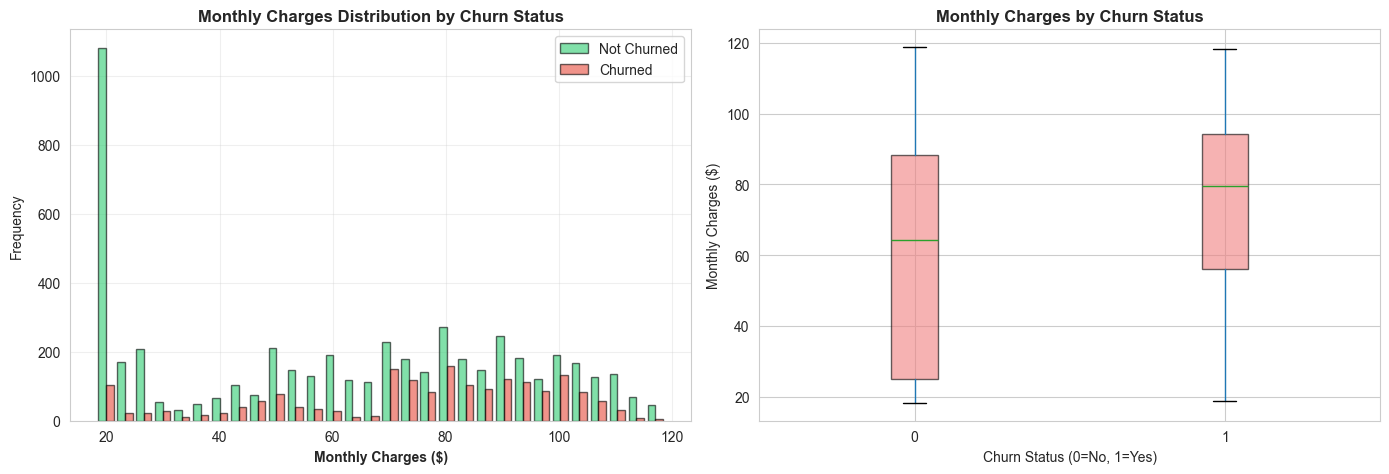


Monthly Charges Statistics by Churn:
              count   mean    std    min    25%    50%   75%     max
Churn Value                                                         
0            5174.0  61.27  31.09  18.25  25.10  64.43  88.4  118.75
1            1869.0  74.44  24.67  18.85  56.15  79.65  94.2  118.35


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# distribution by churn
ax1 = axes[0]
churned_charges = df[df['Churn Value'] == 1]['Monthly Charges']
not_churned_charges = df[df['Churn Value'] == 0]['Monthly Charges']

ax1.hist([not_churned_charges, churned_charges], bins=30, 
         label=['Not Churned', 'Churned'], color=['#2ecc71', '#e74c3c'], 
         alpha=0.6, edgecolor='black')
ax1.set_xlabel('Monthly Charges ($)', fontweight='bold')
ax1.set_ylabel('Frequency')
ax1.set_title('Monthly Charges Distribution by Churn Status', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# box plot
ax2 = axes[1]
df.boxplot(column='Monthly Charges', by='Churn Value', ax=ax2, patch_artist=True,
           boxprops=dict(facecolor='lightcoral', alpha=0.6))
ax2.set_xlabel('Churn Status (0=No, 1=Yes)')
ax2.set_ylabel('Monthly Charges ($)')
ax2.set_title('Monthly Charges by Churn Status', fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.show()

print("\nMonthly Charges Statistics by Churn:")
print(df.groupby('Churn Value')['Monthly Charges'].describe().round(2))

##### **Observation:** Churned customers tend to have higher monthly charges on average ($74 vs $61). This could indicate price sensitivity or perceived value mismatch.

In [21]:
# statistical test
t_stat, p_value = stats.ttest_ind(churned_charges.dropna(), not_churned_charges.dropna())
print(f"T-test results:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4e}")
print(f"\nConclusion: {'Significant difference' if p_value < 0.05 else 'No significant difference'} in monthly charges between churned and retained customers.")

T-test results:
  t-statistic: 16.5367
  p-value: 2.7066e-60

Conclusion: Significant difference in monthly charges between churned and retained customers.


#### 4.3 Correlation Analysis

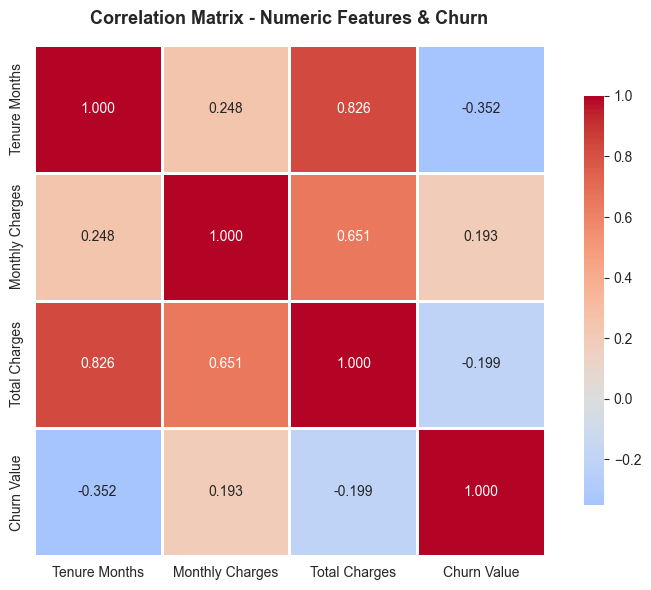

In [22]:
# correlation matrix
corr_cols = ['Tenure Months', 'Monthly Charges', 'Total Charges', 'Churn Value']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Numeric Features & Churn', fontweight='bold', fontsize=13, pad=15)
plt.tight_layout()
plt.show()

##### **Notable Correlations:**
- Tenure and Churn: -0.35 (moderate negative - longer tenure = less churn)
- Monthly Charges and Churn: +0.19 (weak positive - higher charges = slightly more churn)
- Total Charges strongly correlated with Tenure (makes sense - longer customers pay more total)

#### 5. Categorical Features Analysis

#### 5.1 Demographics

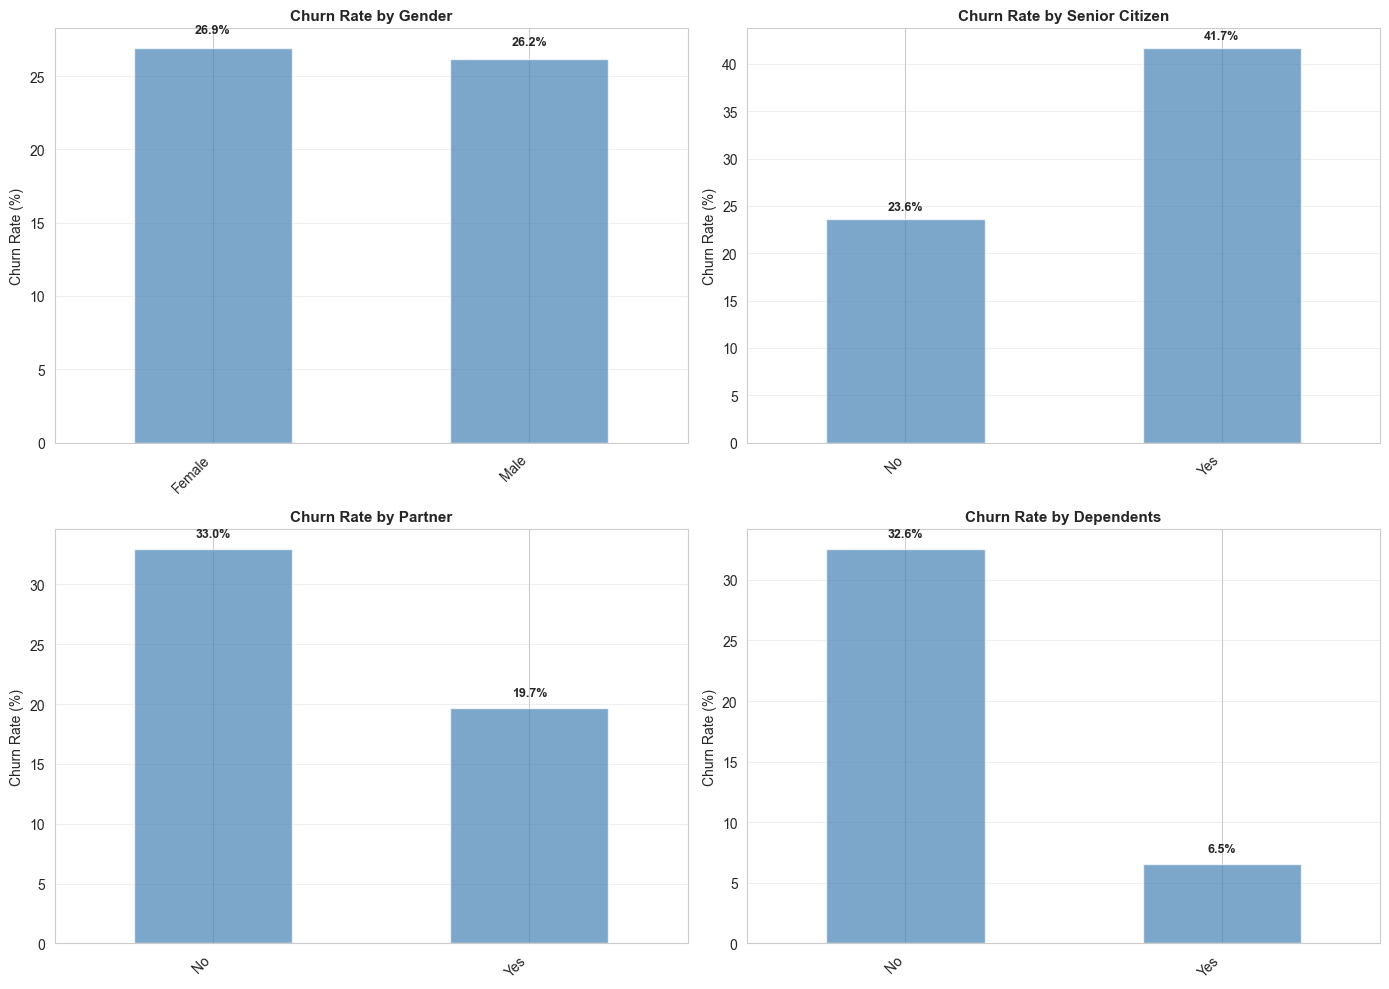

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
demo_cols = ['Gender', 'Senior Citizen', 'Partner', 'Dependents']

for idx, col in enumerate(demo_cols):
    ax = axes[idx // 2, idx % 2]
    
    # calculate churn rate by category
    churn_by_cat = df.groupby(col)['Churn Value'].agg(['sum', 'count', 'mean'])
    churn_by_cat.columns = ['Churned', 'Total', 'Churn_Rate']
    churn_by_cat['Churn_Rate'] = churn_by_cat['Churn_Rate'] * 100
    
    # plot
    churn_by_cat['Churn_Rate'].plot(kind='bar', ax=ax, color='steelblue', alpha=0.7)
    ax.set_title(f'Churn Rate by {col}', fontweight='bold', fontsize=11)
    ax.set_ylabel('Churn Rate (%)')
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    # add values on bars
    for i, v in enumerate(churn_by_cat['Churn_Rate']):
        ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

In [24]:
# detailed breakdown
print("Demographic Factors - Churn Analysis:\n")
for col in demo_cols:
    churn_rate = df.groupby(col)['Churn Value'].mean() * 100
    print(f"\n{col}:")
    print(churn_rate.sort_values(ascending=False))
    print("-" * 40)

Demographic Factors - Churn Analysis:


Gender:
Gender
Female    26.920872
Male      26.160338
Name: Churn Value, dtype: float64
----------------------------------------

Senior Citizen:
Senior Citizen
Yes    41.681261
No     23.606168
Name: Churn Value, dtype: float64
----------------------------------------

Partner:
Partner
No     32.957979
Yes    19.664903
Name: Churn Value, dtype: float64
----------------------------------------

Dependents:
Dependents
No     32.551699
Yes     6.515058
Name: Churn Value, dtype: float64
----------------------------------------


##### **Findings:**
- Gender shows minimal difference in churn rates (~26% for both)
- Senior citizens have slightly higher churn (41% vs 24%)
- Customers without partners have notably higher churn (33% vs 20%)
- Customers without dependents also churn more (31% vs 16%)

#### 5.2 Service Features

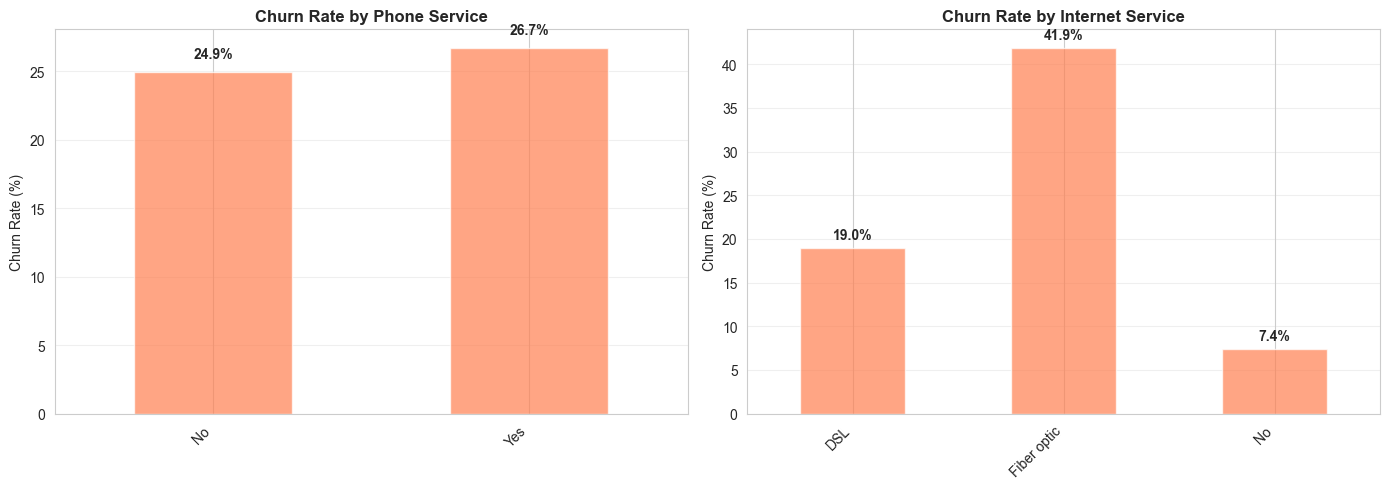

In [25]:
# phone and internet services
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

service_cols = ['Phone Service', 'Internet Service']

for idx, col in enumerate(service_cols):
    ax = axes[idx]
    churn_by_service = df.groupby(col)['Churn Value'].mean() * 100
    
    churn_by_service.plot(kind='bar', ax=ax, color='coral', alpha=0.7)
    ax.set_title(f'Churn Rate by {col}', fontweight='bold', fontsize=12)
    ax.set_ylabel('Churn Rate (%)')
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(churn_by_service):
        ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

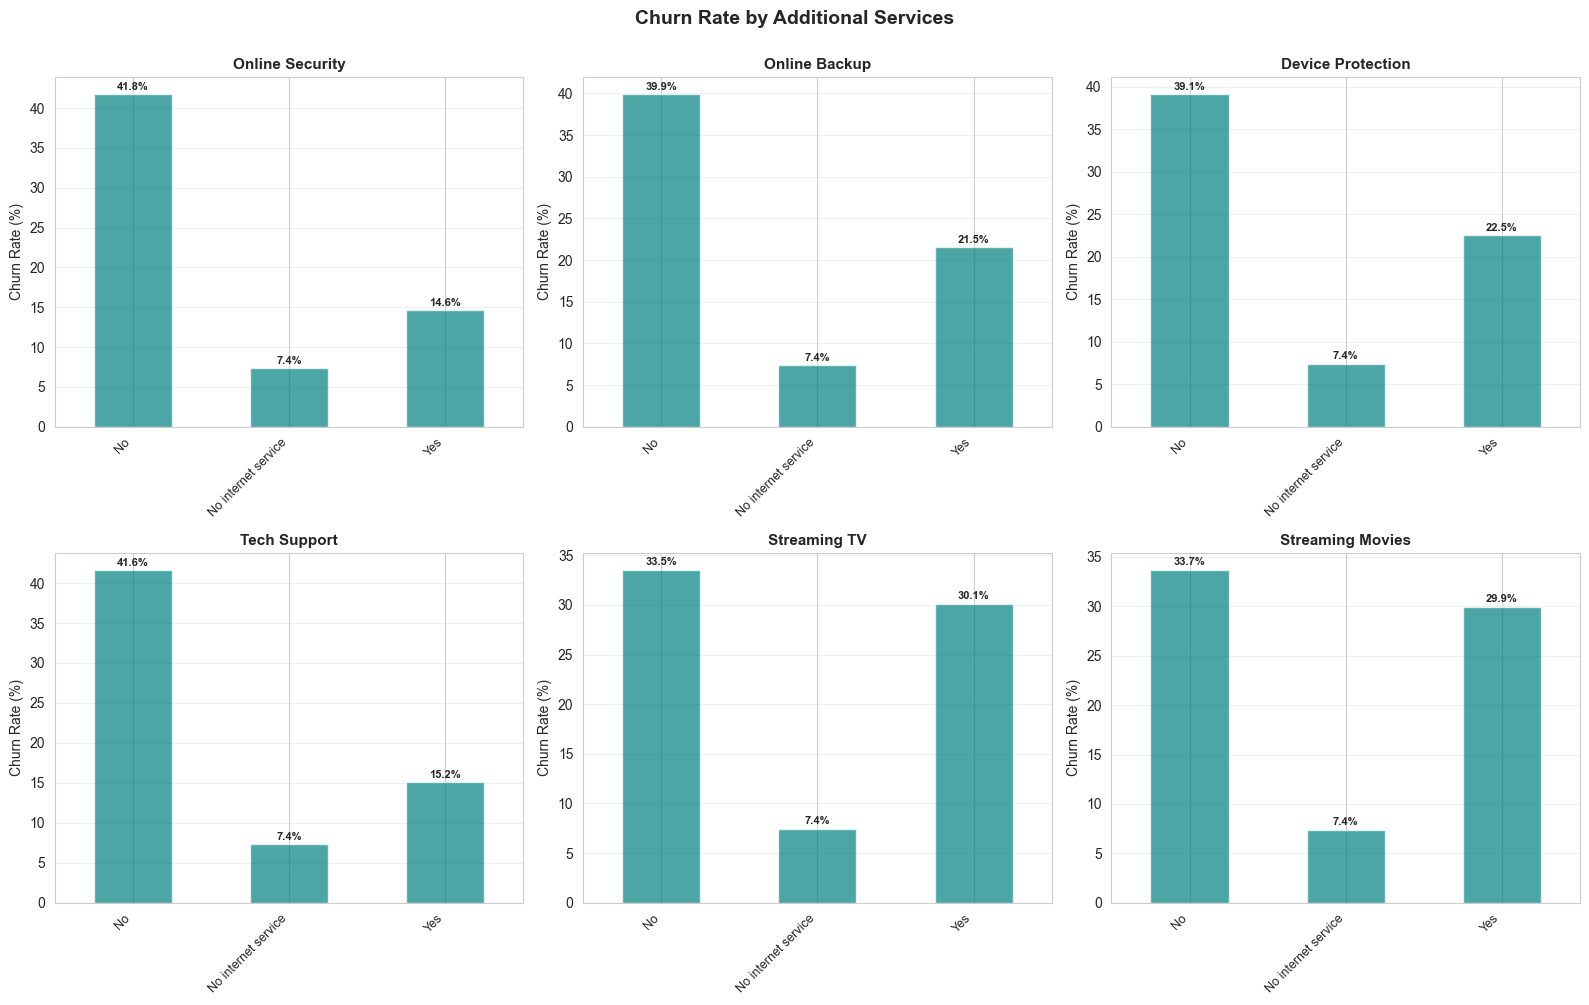

In [26]:
# additional services
add_services = ['Online Security', 'Online Backup', 'Device Protection', 
                'Tech Support', 'Streaming TV', 'Streaming Movies']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(add_services):
    ax = axes[idx]
    churn_by_service = df.groupby(col)['Churn Value'].mean() * 100
    
    churn_by_service.plot(kind='bar', ax=ax, color='teal', alpha=0.7)
    ax.set_title(f'{col}', fontweight='bold', fontsize=11)
    ax.set_ylabel('Churn Rate (%)')
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(churn_by_service):
        ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=8, fontweight='bold')

plt.suptitle('Churn Rate by Additional Services', fontweight='bold', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

##### **Key Observations:**
- Fiber optic internet customers have much higher churn (42%) vs DSL (19%)
- Customers WITHOUT security/backup/protection services churn at much higher rates
- Having any additional service seems to reduce churn significantly

#### 5.3 Contract Type - Critical Analysis

In [27]:
# contract analysis
contract_analysis = df.groupby('Contract').agg({
    'Churn Value': ['count', 'sum', 'mean']
}).round(3)
contract_analysis.columns = ['Total Customers', 'Churned', 'Churn Rate']
contract_analysis['Churn Rate'] = contract_analysis['Churn Rate'] * 100

print("Contract Type Analysis:")
print(contract_analysis)
print()

Contract Type Analysis:
                Total Customers  Churned  Churn Rate
Contract                                            
Month-to-month             3875     1655        42.7
One year                   1473      166        11.3
Two year                   1695       48         2.8



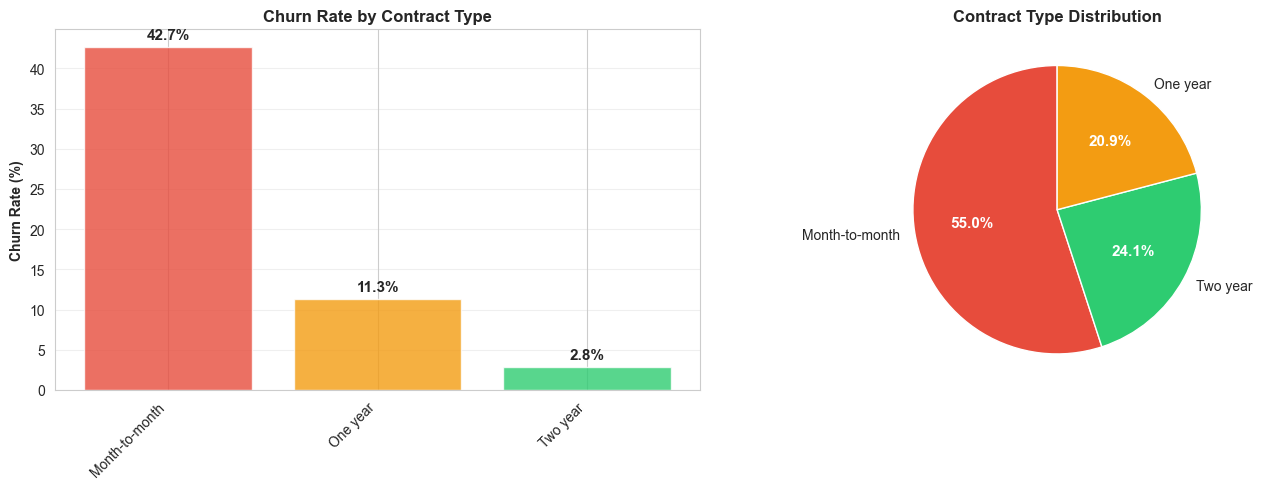

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# churn rate by contract
ax1 = axes[0]
contract_churn_rate = df.groupby('Contract')['Churn Value'].mean() * 100
bars = ax1.bar(range(len(contract_churn_rate)), contract_churn_rate.values, 
               color=['#e74c3c', '#f39c12', '#2ecc71'], alpha=0.8)
ax1.set_xticks(range(len(contract_churn_rate)))
ax1.set_xticklabels(contract_churn_rate.index, rotation=45, ha='right')
ax1.set_ylabel('Churn Rate (%)', fontweight='bold')
ax1.set_title('Churn Rate by Contract Type', fontweight='bold', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, contract_churn_rate.values)):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 1, 
             f'{val:.1f}%', ha='center', fontweight='bold', fontsize=11)

# distribution of contracts
ax2 = axes[1]
contract_dist = df['Contract'].value_counts()
colors = ['#e74c3c', '#2ecc71', '#f39c12']
wedges, texts, autotexts = ax2.pie(contract_dist, labels=contract_dist.index, 
                                     autopct='%1.1f%%', colors=colors, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)
ax2.set_title('Contract Type Distribution', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

##### **CRITICAL FINDING:** Contract type is the strongest predictor of churn!
- Month-to-month: 42.7% churn rate (!)
- One year: 11.3% churn
- Two year: 2.8% churn

Month-to-month customers are 15x more likely to churn than two-year contract customers.

#### 5.4 Payment Method

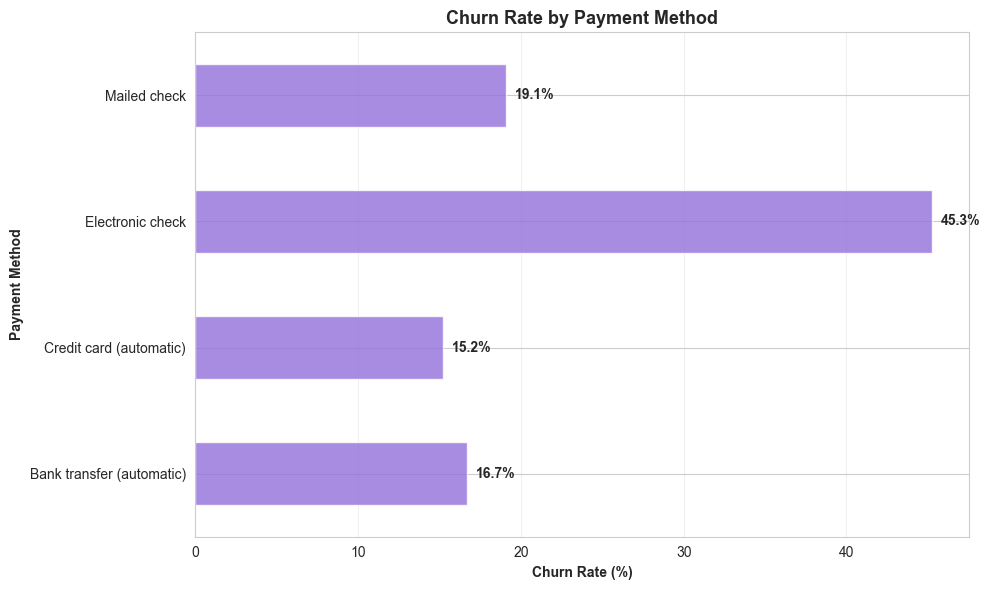

In [29]:
payment_churn = df.groupby('Payment Method')['Churn Value'].mean() * 100

plt.figure(figsize=(10, 6))
ax = payment_churn.plot(kind='barh', color='mediumpurple', alpha=0.8)
ax.set_xlabel('Churn Rate (%)', fontweight='bold')
ax.set_ylabel('Payment Method', fontweight='bold')
ax.set_title('Churn Rate by Payment Method', fontweight='bold', fontsize=13)
ax.grid(axis='x', alpha=0.3)

for i, v in enumerate(payment_churn):
    ax.text(v + 0.5, i, f'{v:.1f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

##### Finding: Electronic check users have notably higher churn (45%) compared to automatic payment methods (15-18%). This suggests payment friction or lack of commitment.

#### 6. Multi-variate Analysis

#### 6.1 Contract vs Tenure

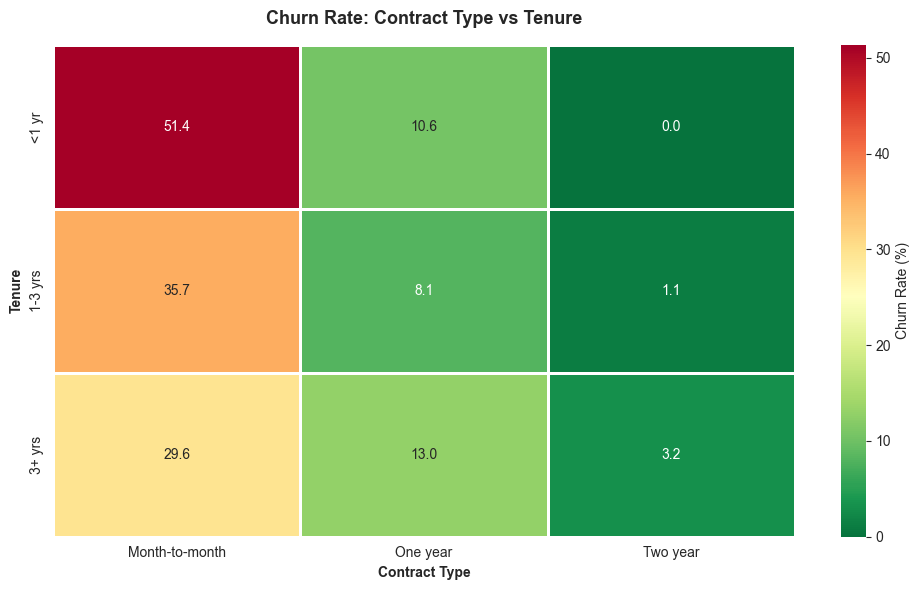


Churn Rate (%) by Contract and Tenure:
Contract    Month-to-month  One year  Two year
Tenure_Bin                                    
<1 yr                 51.4      10.6       0.0
1-3 yrs               35.7       8.1       1.1
3+ yrs                29.6      13.0       3.2


In [30]:
# create tenure bins
df['Tenure_Bin'] = pd.cut(df['Tenure Months'], bins=[0, 12, 36, 72], labels=['<1 yr', '1-3 yrs', '3+ yrs'])

# cross-tab analysis
ct = pd.crosstab(df['Tenure_Bin'], df['Contract'], values=df['Churn Value'], aggfunc='mean') * 100

plt.figure(figsize=(10, 6))
sns.heatmap(ct, annot=True, fmt='.1f', cmap='RdYlGn_r', center=25, 
            cbar_kws={'label': 'Churn Rate (%)'}, linewidths=1)
plt.title('Churn Rate: Contract Type vs Tenure', fontweight='bold', fontsize=13, pad=15)
plt.xlabel('Contract Type', fontweight='bold')
plt.ylabel('Tenure', fontweight='bold')
plt.tight_layout()
plt.show()

print("\nChurn Rate (%) by Contract and Tenure:")
print(ct.round(1))

##### Insight: Even among month-to-month contracts, longer tenure reduces churn. However, contract type remains the dominant factor.

#### 6.2 Internet Service vs Additional Services

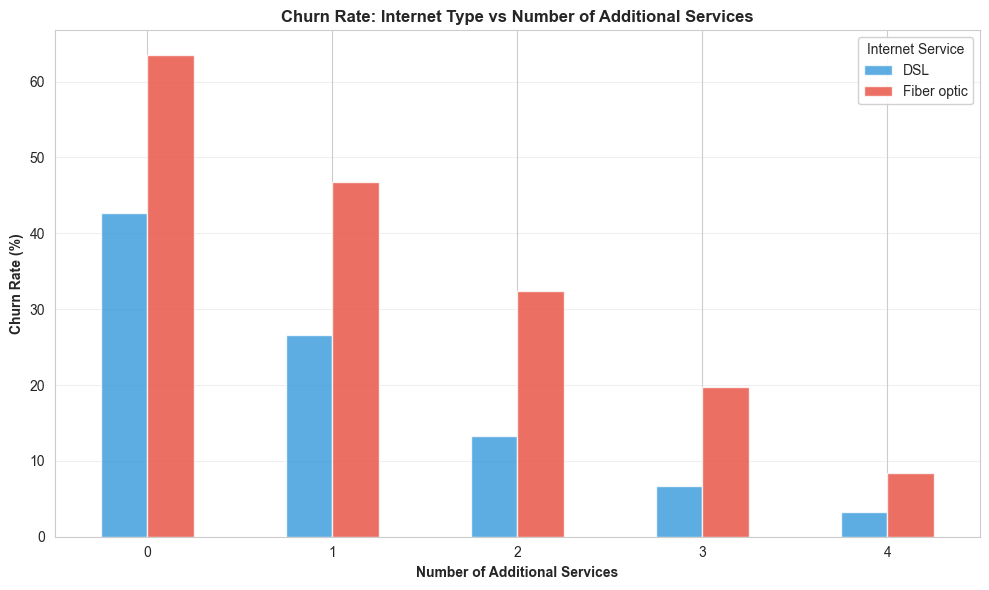

In [31]:
# focus on customers with internet
internet_df = df[df['Internet Service'] != 'No'].copy()

# count of additional services
service_cols = ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support']
internet_df['Num_Services'] = 0
for col in service_cols:
    internet_df['Num_Services'] += (internet_df[col] == 'Yes').astype(int)

# churn by internet type and number of services
pivot_data = internet_df.groupby(['Internet Service', 'Num_Services'])['Churn Value'].mean() * 100
pivot_data = pivot_data.unstack(fill_value=0)

plt.figure(figsize=(10, 6))
pivot_data.T.plot(kind='bar', ax=plt.gca(), color=['#3498db', '#e74c3c'], alpha=0.8)
plt.xlabel('Number of Additional Services', fontweight='bold')
plt.ylabel('Churn Rate (%)', fontweight='bold')
plt.title('Churn Rate: Internet Type vs Number of Additional Services', fontweight='bold', fontsize=12)
plt.legend(title='Internet Service', framealpha=0.9)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

##### Observation: Adding more services consistently reduces churn for both DSL and Fiber customers. However, Fiber customers always have higher churn at every service level.

#### 6.3 Charges vs Tenure (Scatter Analysis)

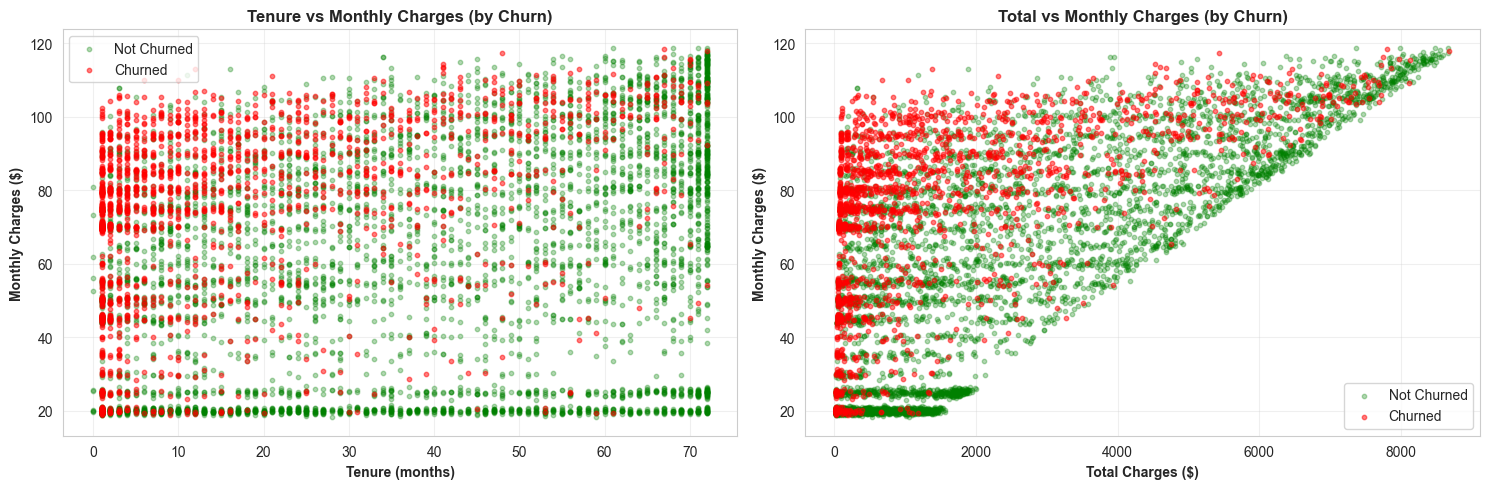

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# scatter: tenure vs monthly charges
ax1 = axes[0]
churned_mask = df['Churn Value'] == 1
ax1.scatter(df[~churned_mask]['Tenure Months'], df[~churned_mask]['Monthly Charges'], 
            alpha=0.3, s=10, c='green', label='Not Churned')
ax1.scatter(df[churned_mask]['Tenure Months'], df[churned_mask]['Monthly Charges'], 
            alpha=0.5, s=10, c='red', label='Churned')
ax1.set_xlabel('Tenure (months)', fontweight='bold')
ax1.set_ylabel('Monthly Charges ($)', fontweight='bold')
ax1.set_title('Tenure vs Monthly Charges (by Churn)', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# scatter: total charges vs monthly charges
ax2 = axes[1]
ax2.scatter(df[~churned_mask]['Total Charges'], df[~churned_mask]['Monthly Charges'], 
            alpha=0.3, s=10, c='green', label='Not Churned')
ax2.scatter(df[churned_mask]['Total Charges'], df[churned_mask]['Monthly Charges'], 
            alpha=0.5, s=10, c='red', label='Churned')
ax2.set_xlabel('Total Charges ($)', fontweight='bold')
ax2.set_ylabel('Monthly Charges ($)', fontweight='bold')
ax2.set_title('Total vs Monthly Charges (by Churn)', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

##### Pattern: Churned customers cluster in the low tenure + high monthly charges area. This is the danger zone - new customers paying premium prices.

#### 7. Churn Reasons Analysis

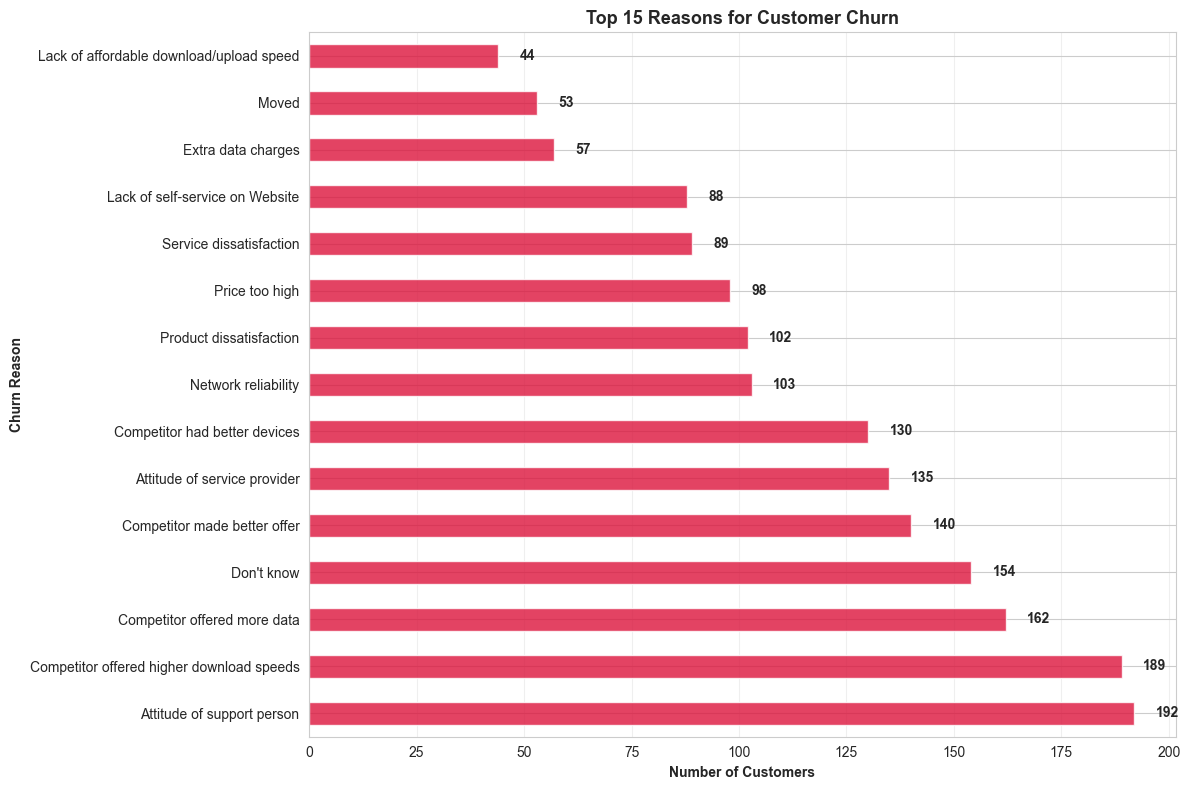

In [34]:
# only look at churned customers who have a reason
churn_reasons = df[df['Churn Value'] == 1]['Churn Reason'].value_counts()

plt.figure(figsize=(12, 8))
ax = churn_reasons.head(15).plot(kind='barh', color='crimson', alpha=0.8)
ax.set_xlabel('Number of Customers', fontweight='bold')
ax.set_ylabel('Churn Reason', fontweight='bold')
ax.set_title('Top 15 Reasons for Customer Churn', fontweight='bold', fontsize=13)
ax.grid(axis='x', alpha=0.3)

# add counts
for i, v in enumerate(churn_reasons.head(15)):
    ax.text(v + 5, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

Reasons:
1. Competitor made better offer - most common
2. Competitor had better devices
3. Attitude of support person
4. Price too high

These are actionable insights for retention strategies.

#### 8. Key Findings Summary

Demographics:
- No partner or dependents
- Senior citizens (slightly higher risk)

Service Characteristics:
- Month-to-month contract (CRITICAL - 42% churn rate)
- Fiber optic internet (42% churn vs 19% for DSL)
- No additional services (security, backup, etc.)
- Electronic check payment

Financial:
- Short tenure (< 1 year)
- High monthly charges ($70-100+)
- Low total charges (due to short tenure)

### Protective Factors:
- Long-term contracts (One or Two year)
- Multiple additional services
- Automatic payment methods
- Longer tenure (3+ years)
- Having family (partner/dependents)

### Recommendations:
1. Contract Strategy: Aggressive incentives to convert month-to-month to annual contracts
2. Service Bundles: Promote security/backup services, especially to Fiber customers
3. Payment Methods: Encourage automatic payments with small discounts
4. New Customer Focus: Extra attention to customers in first 12 months
5. Competitive Response: Address pricing and device quality concerns
6. Support Quality: Training for support staff (attitude was top-3 churn reason)

#### 9. Data Quality Notes for Modeling

In [36]:
print("Features to DROP for modeling: CustomerID (identifier), Churn Label (redundant with Churn Value), Churn Score (would cause data leakage, CLTV (would cause data leakage, Churn Reason (only available after churn), Geographic features (Country, State, City, Zip, Lat/Long) - not predictive")
print()
print("Features to KEEP:")
numeric = ['Tenure Months', 'Monthly Charges', 'Total Charges']
categorical = ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
               'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup',
               'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
               'Contract', 'Paperless Billing', 'Payment Method']
print(f"  Numeric ({len(numeric)}): {numeric}")
print(f"  Categorical ({len(categorical)}): {categorical}")
print(f"\nTotal predictive features: {len(numeric) + len(categorical)}")

Features to DROP for modeling: CustomerID (identifier), Churn Label (redundant with Churn Value), Churn Score (would cause data leakage, CLTV (would cause data leakage, Churn Reason (only available after churn), Geographic features (Country, State, City, Zip, Lat/Long) - not predictive

Features to KEEP:
  Numeric (3): ['Tenure Months', 'Monthly Charges', 'Total Charges']
  Categorical (16): ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']

Total predictive features: 19


In [37]:
# final check on target distribution
print("Target Variable (Churn Value):")
print(df['Churn Value'].value_counts())
print(f"\nClass imbalance ratio: {df['Churn Value'].value_counts()[0] / df['Churn Value'].value_counts()[1]:.2f}:1")
print("\nNote: This imbalance should be considered when training models (stratified splitting, etc.)")

Target Variable (Churn Value):
Churn Value
0    5174
1    1869
Name: count, dtype: int64

Class imbalance ratio: 2.77:1

Note: This imbalance should be considered when training models (stratified splitting, etc.)


## Conclusion

Through this EDA I have been able to uncover clear patterns in customer churn:

The single most important factor is contract type. Month-to-month customers are dramatically more likely to churn than those with annual contracts. Combined with short tenure and high monthly charges, this creates the perfect combination for churn.

The good news is that many of these risk factors are addressable through business actions:
- Offer contract conversion incentives
- Bundle additional services
- Improve support quality
- Focus retention efforts on first-year customers

This analysis provides a solid foundation for building a predictive model and developing targeted retention strategies.

